In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
lx_file = "./data/201909_lx_events.csv"
    
objects = ("XAZR_LX_12_4","XAZR_LX_7_0","XR_LX_10_1","XR_LX_11_7","XR_LX_12_1t1","XR_LX_12_1t2","XR_LX_12_4",
            "XR_LX_12_6","XR_LX_13_7","XR_LX_14_9","XR_LX_15_6","XR_LX_21_3","XR_LX_23_1_1","XR_LX_23_1_2",
            "XR_LX_23_2_1","XR_LX_23_2_2","XR_LX_5_3","XR_LX_5_4","XR_LX_5_5t1","XR_LX_5_5t2","XR_LX_6_0",
            "XR_LX_7_0","XR_LX_7_7t1","XR_LX_7_7t2","XCPR_LX_10_1","XCPR_LX_11_7","XCPR_LX_12_1t1","XCPR_LX_12_1t2",
            "XCPR_LX_12_4","XCPR_LX_12_6","XCPR_LX_13_7","XCPR_LX_14_9","XCPR_LX_15_6","XCPR_LX_21_3","XCPR_LX_23_1_1",
            "XCPR_LX_23_1_2","XCPR_LX_23_2_1","XCPR_LX_23_2_2","XCPR_LX_5_3","XCPR_LX_5_4","XCPR_LX_5_5t1","XCPR_LX_5_5t2",
            "XCPR_LX_6_0","XCPR_LX_7_0","XCPR_LX_7_7t1","XCPR_LX_7_7t2","XKTEPR_LX_10_1","XKTEPR_LX_11_7","XKTEPR_LX_12_1t1",
            "XKTEPR_LX_12_1t2","XKTEPR_LX_12_4","XKTEPR_LX_12_6","XKTEPR_LX_13_7","XKTEPR_LX_14_9","XKTEPR_LX_15_6",
            "XKTEPR_LX_21_3","XKTEPR_LX_23_1_1","XKTEPR_LX_23_1_2","XKTEPR_LX_23_2_1","XKTEPR_LX_23_2_2","XKTEPR_LX_5_3",
            "XKTEPR_LX_5_4","XKTEPR_LX_5_5t1","XKTEPR_LX_5_5t2","XKTEPR_LX_6_0","XKTEPR_LX_7_0","XKTEPR_LX_7_7t1","XKTEPR_LX_7_7t2")

In [3]:
datecol = ['datetime']
df = pd.read_csv(lx_file, sep=';', parse_dates=datecol, dayfirst=True, infer_datetime_format=True)

In [4]:
df.drop(columns=['logfile','type','event'], inplace=True)

In [5]:
df.sort_values(by='datetime', inplace=True)
df.reset_index(drop=True, inplace=True)
df[['func','lx']] = df.object.str.split('_',1, expand=True)

In [6]:
df['lx_closed_time'] = ""
df['lx_closed_time'] = pd.to_numeric(df.lx_closed_time)
df['lx_alarm_time'] = ""
df['lx_alarm_time'] = pd.to_numeric(df.lx_alarm_time)
df['lx_xr_time'] = ""
df['lx_xr_time'] = pd.to_numeric(df.lx_xr_time)
df['lx_act_time'] = ""
df['lx_act_time'] = pd.to_numeric(df.lx_act_time)
df['deltaT_func'] = ""
df['deltaT0_1'] = ""
df['deltaT0_2'] = ""
df['deltaT0_L'] = ""
df['deltaT_lx'] = ""
df['lx_open_error'] = ""
df['lx_passage'] = ""
df['lx_other_error'] = ""
df['lx_input_error'] = ""
df['lx_closed_long'] = ""
df['lx_xcpr_repeat'] = ""
df['lx_xktepr_repeat'] = ""
df['lx_note'] = ""

tmin = df.datetime.min()
tmax = df.datetime.max()
maxsec = int((tmax-tmin)/np.timedelta64(1,'s'))
lx_name = set(df.lx)

In [7]:
new_df = pd.DataFrame()
    
for lx in objects:
    new_df = df[df.object==lx]
    new_df = new_df.assign(deltaT_func = lambda x: (x.datetime - x.datetime.shift(1, axis = 0))/np.timedelta64(1,'s')) # delta tijd per functie event
    new_df = new_df.assign(deltaT0_1 = lambda x: (x.datetime - tmin)/np.timedelta64(1,'s'))
    new_df = new_df.assign(deltaT0_2 = lambda x: x.deltaT0_1.shift(-1, axis = 0))
    new_df.loc[new_df.deltaT0_2.isnull(), 'deltaT0_2'] = maxsec
    new_df = new_df.assign(deltaT0_L = lambda x: x.deltaT0_2 - x.deltaT0_1)
    df.update(new_df)

In [8]:
df.sort_values(by='datetime', inplace=True)

for lx in lx_name:
    new_df = df[df.lx==lx]
    new_df = new_df.assign(deltaT_lx = lambda x: (x.datetime - x.datetime.shift(1, axis = 0))/np.timedelta64(1,'s')) # delta tijd per lx event
    df.update(new_df)

In [9]:
functions = ['XR','XCPR'] 
for lx in lx_name:
    new_df = df[df.lx==lx]
    new_df = new_df.sort_values(by='datetime')
    new_df = new_df[new_df.func.isin(functions)] # maak een dataframe met alleen xr en xcpr
    new_df.loc[(((new_df['func']=='XCPR') & (new_df['value']==1)) & 
                ((new_df['func'].shift(1)=='XR') & (new_df['value'].shift(1)>=1)) & 
                ((new_df['func'].shift(2)=='XR') & (new_df['value'].shift(2)>=1)) & 
                ((new_df['func'].shift(3)=='XR') & (new_df['value'].shift(3)==1))), 
                ['lx_passage','lx_note']] = ["LX double passage"]*2
   
    new_df.loc[(((new_df['func']=='XCPR') & (new_df['value']==1)) & 
                ((new_df['func'].shift(1)=='XR') & (new_df['value'].shift(1)==2)) & 
                ((new_df['func'].shift(2)=='XR') & (new_df['value'].shift(2)==1)) & 
                ((new_df['func'].shift(3)=='XCPR') & (new_df['value'].shift(3)==2)) & 
                ((new_df['func'].shift(4)=='XR') & (new_df['value'].shift(4)==1))), 
                ['lx_passage','lx_note']] = ["LX single passage"]*2

    new_df.loc[(((new_df['func']=='XCPR') & (new_df['value']==1)) &  
                ((new_df['func'].shift(1)!='XR'))), 
                ['lx_open_error','lx_note']] = ["XCPR off and no XR on before"]*2
    df.update(new_df)

In [10]:

functions = ['XR','XCPR','XKTEPR'] 
for lx in lx_name:
    new_df = df[df.lx==lx]
    new_df = new_df.sort_values(by='datetime')
    new_df = new_df[new_df.func.isin(functions)] # maak een dataframe met alleen xr en xcpr en xktepr
        
    new_df.loc[((new_df.value.isin([0,3])) & (new_df.func.isin(functions[1:]))), 
                ['lx_input_error','lx_note']] = ["Short/OOC on input"]*2

    new_df.loc[(((new_df.func=='XKTEPR') & (new_df.value==1)) & 
                ((new_df.func.shift(1)=='XR') & (new_df.value.shift(1)==2))), 
                ['lx_other_error','lx_note']] = ["XKTEPR off after XR on"]*2

    new_df.loc[(((new_df.func=='XKTEPR') & (new_df.value==1)) & 
                ((new_df.func.shift(1)=='XCPR') & (new_df.value.shift(1)>=1))), 
                ['lx_closed_long','lx_note']] = ["LX closed too long"]*2

    new_df.loc[(((new_df.func=='XKTEPR') & (new_df.value==1)) & 
                ((new_df.func.shift(1)=='XR') & (new_df.value.shift(1)==1))), 
                ['lx_closed_long','lx_note']] = ["LX closed too long"]*2

    new_df.loc[(((new_df.func=='XKTEPR') & (new_df.value==1)) & 
                ((new_df.func.shift(-1)=='XKTEPR') & (new_df.value.shift(-1)==2))), 
                ['lx_xktepr_repeat','lx_note']] = ["XKTEPR repeat"]*2

    new_df.loc[(((new_df.func=='XCPR') & (new_df.value==2)) & 
                ((new_df.func.shift(1)=='XCPR') & (new_df.value.shift(1)==1)) &  
                ((new_df.func.shift(2)=='XCPR'))), 
                ['lx_xcpr_repeat','lx_note']] =   ["XCPR repeat"]*2
    df.update(new_df)


In [11]:
# bepaal de lx_closed_time plot 2
for lx in lx_name:
    new_df = df[df.lx==lx]
    new_df = new_df[new_df.func=='XCPR']
    new_df = new_df.sort_values(by='datetime')

    new_df.loc[(((new_df['func']=='XCPR') & (new_df['value']==1)) & 
                ((new_df['func'].shift(1)=='XCPR') & (new_df['value'].shift(1)==2))), 
                ['lx_closed_time']] = new_df.deltaT0_1 - new_df.deltaT0_1.shift(1)

    df.update(new_df)

In [12]:
#bepaal de lx_alarm_time
for lx in lx_name:
    new_df = df[df.lx==lx]
    new_df = new_df[new_df.func=='XKTEPR']
    new_df = new_df.sort_values(by='datetime')

    new_df.loc[(((new_df['func']=='XKTEPR') & (new_df['value']==2)) & 
                ((new_df['func'].shift(1)=='XKTEPR') & (new_df['value'].shift(1)==1))), 
                ['lx_alarm_time']] = new_df.deltaT0_1 - new_df.deltaT0_1.shift(1)

    df.update(new_df)

In [13]:
# bepaal de xr=down to xr=down time (akd to mid section) plot 3
for lx in lx_name:
    new_df = df[df.lx==lx]
    new_df = new_df[new_df.func=='XR']
    new_df = new_df.sort_values(by='datetime')

    new_df.loc[(((new_df['func']=='XR') & (new_df['value']==1)) & 
                ((new_df['func'].shift(1)=='XR') & (new_df['value'].shift(1)==1))), 
                ['lx_xr_time']] = new_df.deltaT0_1 - new_df.deltaT0_1.shift(1)

    df.update(new_df)

In [14]:
# bepaal de lx activate to lx_closed time plot 4
for lx in lx_name:
    new_df = df[df.lx==lx]
    new_df = new_df[new_df.func.isin(['XCPR','XR'])]
    new_df = new_df.sort_values(by='datetime')

    new_df.loc[(((new_df['func']=='XCPR') & (new_df['value']==2)) & 
                ((new_df['func'].shift(1)=='XR') & (new_df['value'].shift(1)==1))), 
                ['lx_act_time']] = new_df.deltaT0_1 - new_df.deltaT0_1.shift(1)

    df.update(new_df)

## Data voor de statistiek
- lx_xcpr_time
- lx_xktepr_time
- lx_passage
- lx_xr_time
- lx_act_time

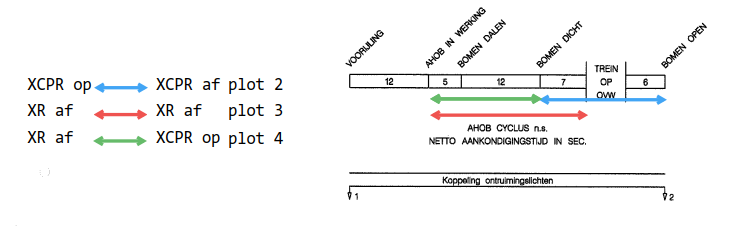

In [15]:
lx_xcpr_time = df.query("func=='XCPR' & value==1")[['datetime','lx','lx_closed_time','lx_note']]
lx_xcpr_time['date'] = lx_xcpr_time['datetime'].dt.date

lx_xktepr_time = df.query("func=='XKTEPR' & value==2")[['datetime','lx','lx_alarm_time']]
lx_xktepr_time['date'] = lx_xktepr_time['datetime'].dt.date

lx_passage = df.query("lx_passage !=''")[['datetime','lx','lx_passage']]
lx_passage['date'] = lx_passage['datetime'].dt.date

lx_xr_time = df.query("func=='XR' & value==1")[['datetime','lx','lx_xr_time','lx_note']].dropna()
lx_xr_time['date'] = lx_xr_time['datetime'].dt.date

lx_act_time = df.query("lx_act_time>=0")[['datetime','lx','lx_act_time','lx_note']]
lx_act_time['date'] = lx_act_time['datetime'].dt.date


# Bepaal de tijd dat de overwegbomen laag zijn:

In [16]:
lx_passage.groupby(['lx','lx_passage']).count().unstack()


datetime                  
lx_passage LX double passage LX single passage
lx                                            
LX_10_1                 43.0            2030.0
LX_11_7                 84.0            1969.0
LX_12_1t1               12.0             971.0
LX_12_4                131.0            1722.0
LX_12_6                173.0            1618.0
LX_13_7                331.0            1298.0
LX_14_9                357.0             206.0
LX_15_6                 31.0            1019.0
LX_21_3                 17.0            1040.0
LX_5_3                 338.0            2228.0
LX_5_4                1417.0            1147.0
LX_5_5t1                74.0            1358.0
LX_5_5t2               985.0             442.0
LX_6_0                 311.0            2287.0
LX_7_7t1                69.0            1041.0
LX_7_7t2                 NaN             998.0

In [17]:
lx_xcpr_time.groupby(['lx']).describe().round(1)

lx_closed_time                                             
                   count  mean    std   min   25%   50%   75%     max
lx                                                                   
LX_10_1           2077.0  19.0    6.8   0.0  17.0  18.0  19.0   155.0
LX_11_7           2062.0  37.0   27.0   3.0  27.0  32.0  37.0   561.0
LX_12_1t1          987.0  27.6   14.1  17.0  22.0  25.0  30.0   311.0
LX_12_4           1860.0  29.5   15.2   6.0  24.0  26.0  30.0   312.0
LX_12_6           1811.0  30.5   14.8   1.0  25.0  27.0  30.0   244.0
LX_13_7           1665.0  35.9  123.6   0.0  22.0  26.0  30.0  4445.0
LX_14_9            569.0  30.8   22.8  16.0  22.0  26.0  31.0   350.0
LX_15_6           1055.0  22.1   14.4   0.0  18.0  21.0  22.0   316.0
LX_21_3           1070.0  18.7    8.3   2.0  15.0  17.0  20.0   142.0
LX_5_3            2572.0  29.7   11.7  19.0  24.0  27.0  31.2   232.0
LX_5_4            2575.0  31.6   12.1   0.0  26.0  29.0  33.0   249.0
LX_5_5t1          1435.0  27.5   12.7  16.0  23.0  26.0  29.0   261.0
LX_5_5t2          1430.0  25.9    6.4  17.0  22.0  24.0  28.8    74.0
LX_6_0            2618.0  35.8   16.7   0.0  27.0  32.0  38.0   317.0
LX_7_7t1          1129.0  29.0   18.3   2.0  22.0  25.0  31.0   261.0
LX_7_7t2          1000.0  27.8    6.3  17.0  25.0  27.0  30.0   124.0

In [34]:
lx_xcpr_time.groupby(['date']).describe().round(1)

lx_closed_time                                             
                    count  mean    std   min   25%   50%   75%     max
date                                                                  
2019-09-01          993.0  46.4  160.7   5.0  25.0  29.0  35.0  4445.0
2019-09-02           53.0  53.2   84.9   7.0  24.0  29.0  38.0   561.0
2019-09-06            4.0   6.5    5.9   2.0   2.8   4.5   8.2    15.0
2019-09-07         1008.0  29.7   23.7   2.0  21.0  26.0  31.0   435.0
2019-09-08         1270.0  29.4   18.3   0.0  23.0  26.0  31.0   317.0
2019-09-09         1643.0  27.0   12.2   1.0  22.0  24.0  29.0   254.0
2019-09-10         1683.0  28.0   10.2  14.0  23.0  26.0  31.0   139.0
2019-09-11         1814.0  27.9    9.2  13.0  22.0  26.0  31.8    79.0
2019-09-12         1817.0  27.8   11.3   0.0  22.0  26.0  30.0   188.0
2019-09-13         1813.0  28.5   15.5   0.0  22.0  26.0  30.0   312.0
2019-09-14         1672.0  27.1    8.7   0.0  22.0  25.0  30.0    91.0
2019-09-15         1867.0  26.8   11.2   0.0  22.0  25.0  29.0   281.0
2019-09-16         1815.0  28.2   13.0   0.0  22.0  25.0  30.0   183.0
2019-09-17         1725.0  30.8   25.3  13.0  22.0  25.0  30.0   316.0
2019-09-18         1851.0  29.8   13.9  14.0  23.0  26.0  32.0   253.0
2019-09-20            1.0  13.0    NaN  13.0  13.0  13.0  13.0    13.0
2019-09-21         1537.0  28.9   11.2  15.0  23.0  27.0  32.0   267.0
2019-09-22         1218.0  29.5    9.8   2.0  24.0  28.0  33.0    98.0
2019-09-23          481.0  30.4   14.6   5.0  24.0  27.0  32.0   187.0
2019-09-24          339.0  36.2   23.0  17.0  26.0  30.0  38.0   201.0
2019-09-25          112.0  30.7   23.3  15.0  24.0  28.0  31.0   241.0
2019-09-26           78.0  24.1    6.2  14.0  21.0  24.0  26.0    47.0
2019-09-28         1121.0  30.8   11.7   1.0  24.0  29.0  36.0   115.0

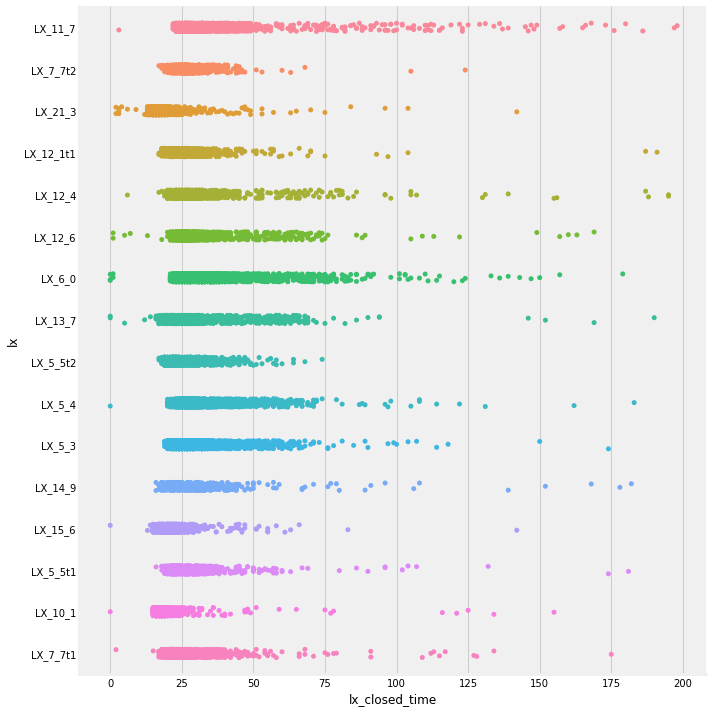

In [18]:
pl1 = sns.catplot('lx_closed_time','lx', data=lx_xcpr_time[lx_xcpr_time.lx_closed_time <= 200], height=10, kind='strip')

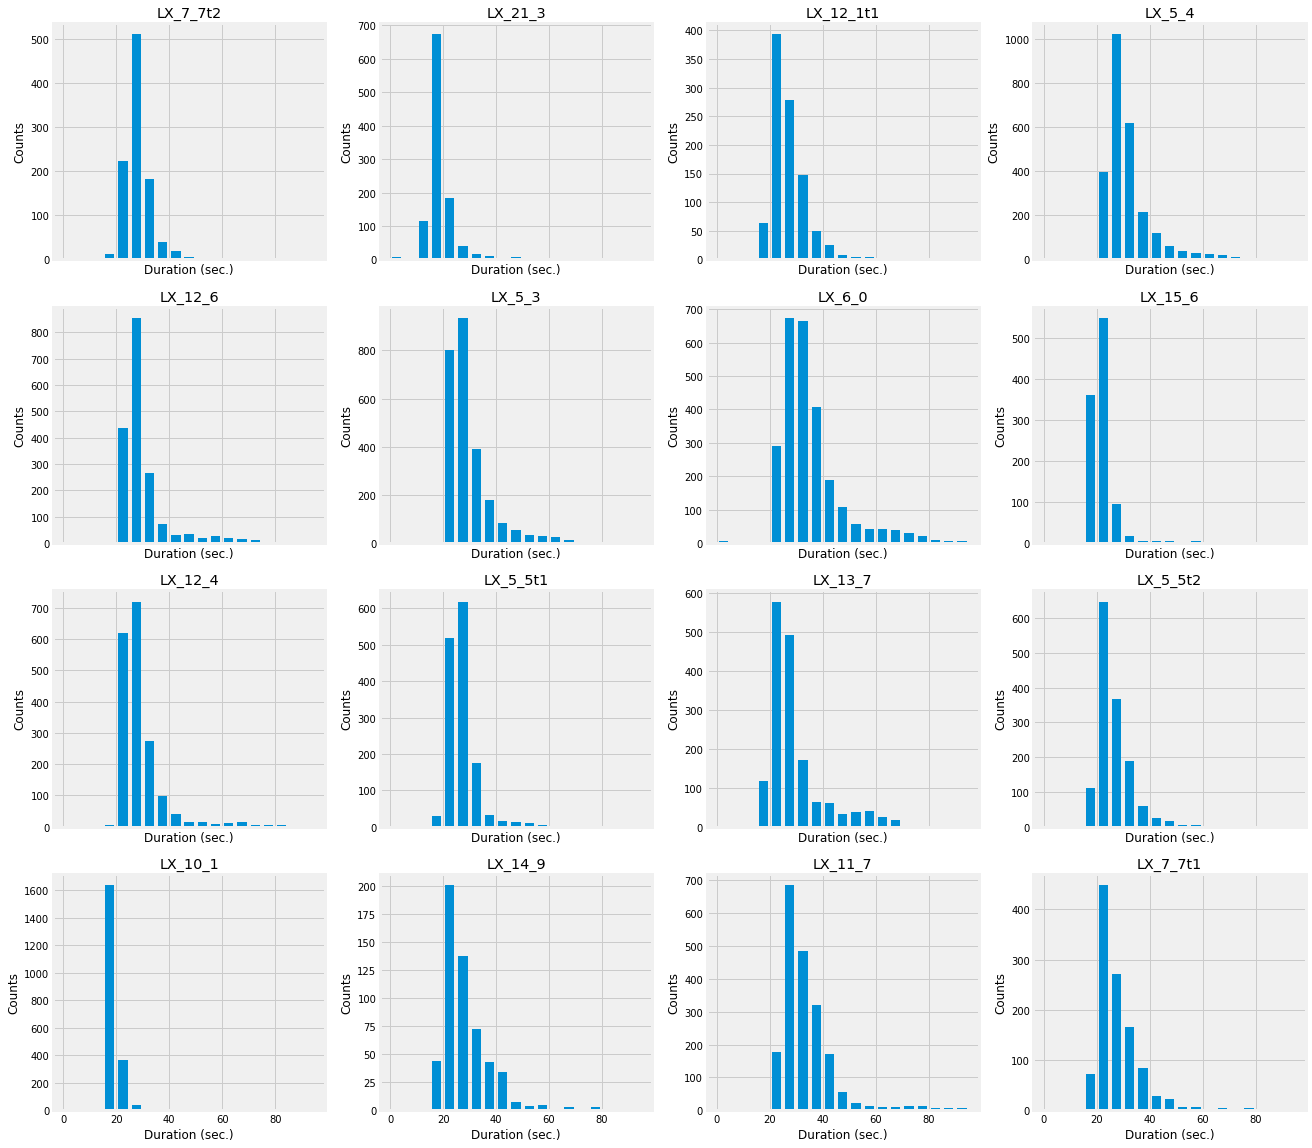

In [19]:
lx_set = set(lx_xcpr_time.lx)
bins = list(range(0,100,5))
num_columns = 4
num_rows = int(np.ceil(len(lx_set)/num_columns))

pl2, our_axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20, 20), 
                             sharex=True, sharey=False)

lx_axes = [ax for ax_row in our_axes for ax in ax_row]

for i, lx in enumerate(lx_set):
    current_ax = lx_axes[i]
    current_lx_data = lx_xcpr_time[lx_xcpr_time.lx==lx].lx_closed_time
    current_ax.hist(current_lx_data, rwidth=0.7, bins=bins, density=False)
    current_ax.set_title(lx)
    current_ax.set_ylabel('Counts')
    current_ax.set_xlabel('Duration (sec.)')

## Overweg dicht tijd >= 30sec

In [20]:
lx_xcpr_time[lx_xcpr_time.lx_closed_time >= 30].groupby(['lx']).describe().round(1)

lx_closed_time                                             
                   count  mean    std   min   25%   50%   75%     max
lx                                                                   
LX_10_1             34.0  56.7   34.0  30.0  35.2  41.0  63.5   155.0
LX_11_7           1200.0  44.9   33.2  30.0  33.0  36.0  41.0   561.0
LX_12_1t1          252.0  38.9   24.2  30.0  31.0  33.0  38.0   311.0
LX_12_4            513.0  42.0   24.6  30.0  31.0  34.0  41.0   312.0
LX_12_6            516.0  42.8   23.3  30.0  31.0  34.0  47.0   244.0
LX_13_7            470.0  67.1  229.8  30.0  32.0  40.0  52.0  4445.0
LX_14_9            186.0  46.1   35.1  30.0  32.0  37.0  43.0   350.0
LX_15_6             50.0  54.8   55.9  30.0  33.0  41.5  51.0   316.0
LX_21_3             47.0  46.9   22.3  30.0  32.5  39.0  49.0   142.0
LX_5_3             830.0  40.0   16.0  30.0  32.0  35.0  43.0   232.0
LX_5_4            1155.0  38.6   15.2  30.0  31.0  34.0  41.0   249.0
LX_5_5t1           268.0  40.0   25.4  30.0  31.0  32.0  38.0   261.0
LX_5_5t2           303.0  35.4    7.0  30.0  31.0  33.0  37.0    74.0
LX_6_0            1649.0  41.9   18.4  30.0  32.0  36.0  44.0   317.0
LX_7_7t1           337.0  42.3   29.1  30.0  32.0  35.0  40.0   261.0
LX_7_7t2           254.0  34.4    9.0  30.0  30.0  32.0  35.0   124.0

## Overweg dicht tijd <= 200sec

In [21]:
lx_xcpr_time[lx_xcpr_time.lx_closed_time <= 200].groupby(['lx']).describe().round(1)

lx_closed_time                                           
                   count  mean   std   min   25%   50%   75%    max
lx                                                                 
LX_10_1           2077.0  19.0   6.8   0.0  17.0  18.0  19.0  155.0
LX_11_7           2053.0  35.8  18.9   3.0  27.0  32.0  37.0  198.0
LX_12_1t1          986.0  27.3  10.9  17.0  22.0  25.0  30.0  191.0
LX_12_4           1859.0  29.4  13.7   6.0  24.0  26.0  30.0  195.0
LX_12_6           1808.0  30.1  12.2   1.0  25.0  27.0  30.0  169.0
LX_13_7           1654.0  29.2  13.0   0.0  22.0  26.0  30.0  190.0
LX_14_9            567.0  29.9  17.1  16.0  22.0  26.0  31.0  182.0
LX_15_6           1053.0  21.6   7.0   0.0  18.0  21.0  22.0  142.0
LX_21_3           1070.0  18.7   8.3   2.0  15.0  17.0  20.0  142.0
LX_5_3            2570.0  29.6  10.3  19.0  24.0  26.5  31.0  174.0
LX_5_4            2573.0  31.5  10.7   0.0  26.0  29.0  33.0  183.0
LX_5_5t1          1433.0  27.2   9.9  16.0  23.0  26.0  29.0  181.0
LX_5_5t2          1430.0  25.9   6.4  17.0  22.0  24.0  28.8   74.0
LX_6_0            2614.0  35.5  14.5   0.0  27.0  32.0  38.0  179.0
LX_7_7t1          1125.0  28.2  12.3   2.0  22.0  25.0  31.0  175.0
LX_7_7t2          1000.0  27.8   6.3  17.0  25.0  27.0  30.0  124.0

## Overweg dicht tijd > 200sec

In [31]:
lx_xcpr_time[lx_xcpr_time.lx_closed_time > 200].groupby(['lx']).describe().round(1)

lx_closed_time                                                     
                   count    mean     std    min    25%    50%     75%     max
lx                                                                           
LX_11_7              9.0   306.6   116.6  219.0  241.0  242.0   320.0   561.0
LX_12_1t1            1.0   311.0     NaN  311.0  311.0  311.0   311.0   311.0
LX_12_4              1.0   312.0     NaN  312.0  312.0  312.0   312.0   312.0
LX_12_6              3.0   234.7     8.3  228.0  230.0  232.0   238.0   244.0
LX_13_7             11.0  1045.6  1177.2  281.0  502.0  624.0  1019.0  4445.0
LX_14_9              2.0   275.5   105.4  201.0  238.2  275.5   312.8   350.0
LX_15_6              2.0   311.0     7.1  306.0  308.5  311.0   313.5   316.0
LX_5_3               2.0   223.0    12.7  214.0  218.5  223.0   227.5   232.0
LX_5_4               2.0   235.0    19.8  221.0  228.0  235.0   242.0   249.0
LX_5_5t1             2.0   240.0    29.7  219.0  229.5  240.0   250.5   261.0
LX_6_0               4.0   242.8    50.2  206.0  218.8  224.0   248.0   317.0
LX_7_7t1             4.0   256.2     3.6  253.0  253.8  255.5   258.0   261.0

# Duur van storingsmelder actief in seconden:


In [22]:
lx_xktepr_time.groupby(['lx']).describe().round(1)

lx_alarm_time                                                 \
                  count    mean     std    min     25%     50%     75%   
lx                                                                       
LX_11_7            18.0    81.9   103.5    4.0    16.2    48.5    80.8   
LX_12_1t1           3.0    68.3    69.9   26.0    28.0    30.0    89.5   
LX_12_4             8.0   511.9  1262.0   28.0    34.2    49.0   127.2   
LX_12_6             5.0    47.6    37.6    4.0    10.0    67.0    73.0   
LX_13_7             2.0  6266.0  8690.3  121.0  3193.5  6266.0  9338.5   
LX_14_9             5.0    54.6    76.7    6.0    17.0    20.0    40.0   
LX_15_6             6.0   498.5   737.3   39.0   145.8   151.5   446.0   
LX_21_3             9.0  2187.9  4571.3    1.0    67.0  1049.0  1419.0   
LX_5_3              3.0    45.0    29.8   12.0    32.5    53.0    61.5   
LX_5_4              3.0    56.7    32.7   22.0    41.5    61.0    74.0   
LX_5_5t1            4.0    47.8    40.1   13.0    18.2    39.0    68.5   
LX_6_0              6.0    69.8    46.4   19.0    51.0    64.0    67.2   
LX_7_7t1            5.0    79.2    37.3   13.0    90.0    92.0   100.0   

                    
               max  
lx                  
LX_11_7      399.0  
LX_12_1t1    149.0  
LX_12_4     3633.0  
LX_12_6       84.0  
LX_13_7    12411.0  
LX_14_9      190.0  
LX_15_6     1961.0  
LX_21_3    14255.0  
LX_5_3        70.0  
LX_5_4        87.0  
LX_5_5t1     100.0  
LX_6_0       157.0  
LX_7_7t1     101.0

## De duur van AKD tot LX midden sectie bezet.
Op bassis van 2x een XR sturing.

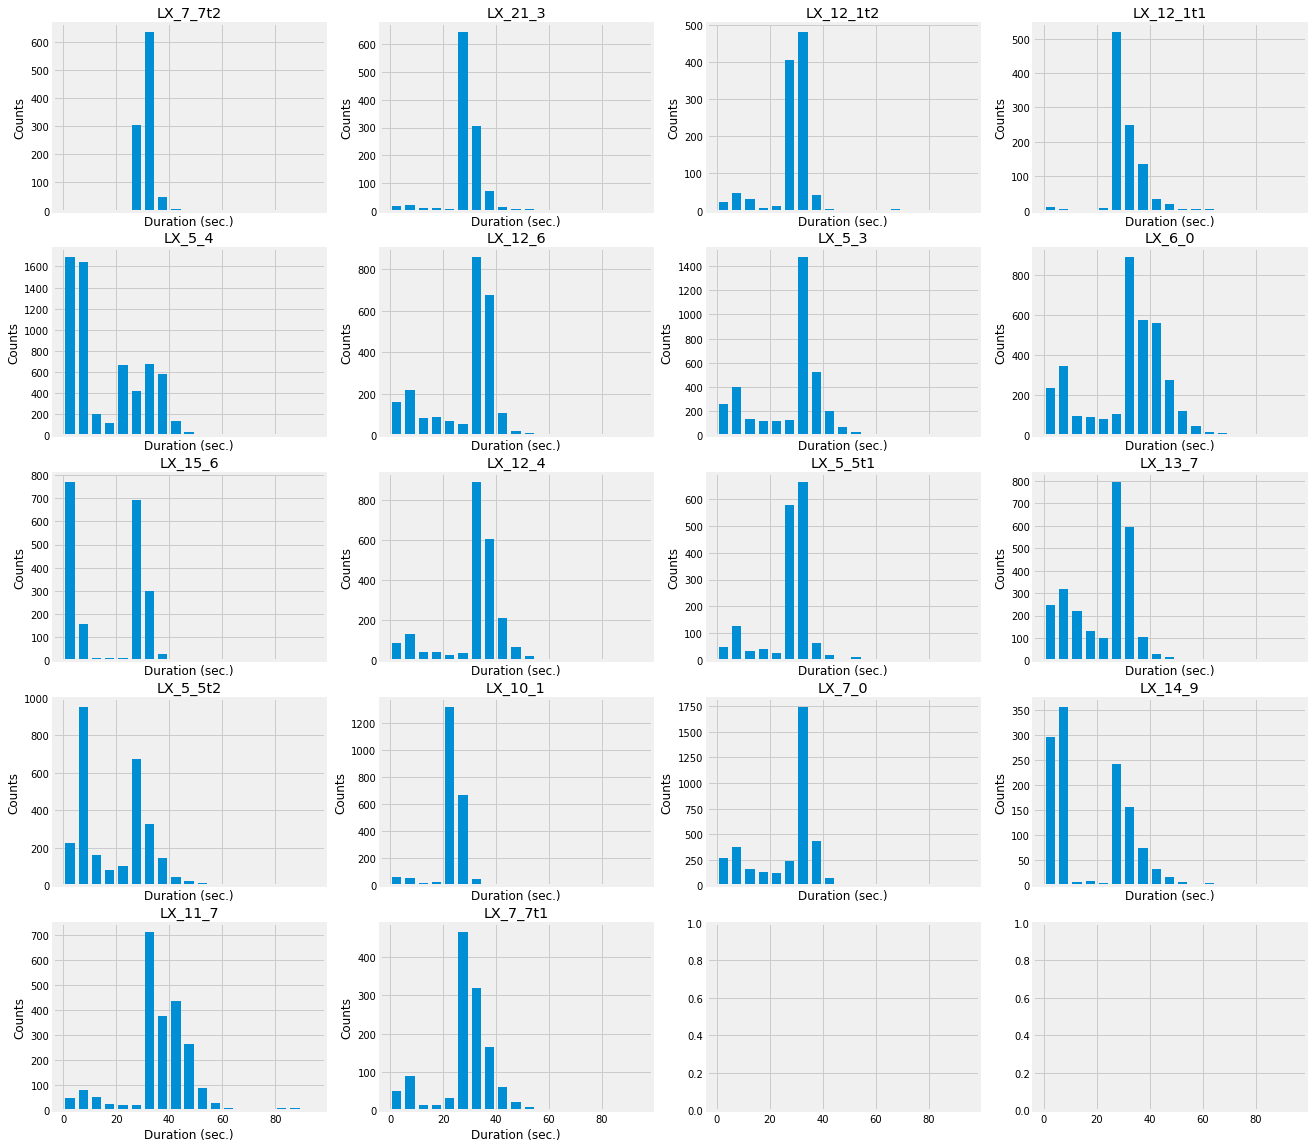

In [23]:
lx_set = set(lx_xr_time.lx)
bins = list(range(0,100,5))
num_columns = 4
num_rows = int(np.ceil(len(lx_set)/num_columns))

pl3, our_axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20, 20), 
                             sharex=True, sharey=False)

lx_axes = [ax for ax_row in our_axes for ax in ax_row]

for i, lx in enumerate(lx_set):
    current_ax = lx_axes[i]
    current_lx_data = lx_xr_time[lx_xr_time.lx==lx].lx_xr_time
    current_ax.hist(current_lx_data, rwidth=0.7, bins=bins, density=False)
    current_ax.set_title(lx)
    current_ax.set_ylabel('Counts')
    current_ax.set_xlabel('Duration (sec.)')
  

In [24]:
lx_xr_time.groupby(['lx','date']).lx_xr_time.describe()

count       mean        std   min    25%   50%     75%  \
lx       date                                                                 
LX_10_1  2019-09-01  138.0  24.282609   4.726056   1.0  24.00  24.0   26.00   
         2019-09-02    6.0  24.333333   0.816497  24.0  24.00  24.0   24.00   
         2019-09-07   97.0  19.319588  12.312381   1.0   8.00  23.0   25.00   
         2019-09-08  113.0  22.451327   5.076189   2.0  23.00  24.0   24.00   
         2019-09-09  142.0  23.788732   4.479791   1.0  23.00  24.0   24.00   
         2019-09-10  152.0  23.177632   4.526745   1.0  23.00  24.0   24.25   
         2019-09-11  142.0  24.154930   3.120047   3.0  24.00  24.0   25.00   
         2019-09-12  146.0  23.116438   4.047154   1.0  23.00  24.0   24.00   
         2019-09-13  135.0  23.674074   3.897626   4.0  23.00  24.0   25.00   
         2019-09-14  129.0  24.930233   3.023827   1.0  24.00  25.0   26.00   
         2019-09-15  146.0  23.993151   3.006881   4.0  23.00  24.0   25.00   
         2019-09-16  147.0  23.129252   5.085936   1.0  23.00  24.0   25.00   
         2019-09-17  142.0  26.098592  18.219431   1.0  24.00  24.0   25.00   
         2019-09-18  136.0  23.941176   6.130391   2.0  23.00  24.0   26.00   
         2019-09-21  142.0  23.373239   4.468343   2.0  23.00  24.0   25.00   
         2019-09-22  108.0  23.962963   3.243760   6.0  23.00  24.0   25.00   
         2019-09-23   40.0  24.900000   7.499744   3.0  24.00  25.0   28.00   
         2019-09-24   25.0  30.440000  13.494073  23.0  24.00  25.0   29.00   
         2019-09-25    8.0  24.625000   1.302470  23.0  24.00  24.0   25.25   
         2019-09-26    6.0  24.500000   0.836660  23.0  24.25  25.0   25.00   
         2019-09-28  105.0  20.523810   6.841749   1.0  23.00  23.0   24.00   
LX_11_7  2019-09-01  137.0  72.978102  47.432997   6.0  37.00  44.0  101.00   
         2019-09-02    6.0  65.500000  32.482303  36.0  36.50  62.0   88.25   
         2019-09-07  101.0  32.425743  44.227898   1.0  13.00  33.0   39.00   
         2019-09-08  114.0  38.675439  20.441800   1.0  33.00  35.5   42.00   
         2019-09-09  141.0  38.432624   8.413684   1.0  33.00  39.0   43.00   
         2019-09-10  152.0  38.322368   9.748222   3.0  33.75  38.5   44.00   
         2019-09-11  148.0  36.966216   9.389106   5.0  33.00  37.0   43.25   
         2019-09-12  155.0  35.348387  10.774304   0.0  33.00  35.0   41.50   
         2019-09-13  136.0  37.375000   8.759281   7.0  33.00  36.0   42.00   
...                    ...        ...        ...   ...    ...   ...     ...   
LX_7_7t1 2019-09-17   77.0  26.545455   9.946628   3.0  25.00  27.0   29.00   
         2019-09-18   85.0  26.717647  20.806141   0.0  21.00  27.0   31.00   
         2019-09-21   77.0  30.194805  10.342858   7.0  27.00  30.0   36.00   
         2019-09-22   56.0  34.053571   6.195070   7.0  31.00  34.0   38.00   
         2019-09-23   27.0  27.555556   9.410850   1.0  27.00  29.0   32.50   
         2019-09-24   14.0  31.357143  11.338207   5.0  28.25  30.0   32.75   
         2019-09-25    4.0  32.500000   4.203173  28.0  30.25  32.0   34.25   
         2019-09-26    3.0  38.000000   8.888194  31.0  33.00  35.0   41.50   
         2019-09-28   45.0  39.777778   5.865496  28.0  36.00  38.0   42.00   
LX_7_7t2 2019-09-01   38.0  34.000000   6.681964  27.0  30.25  33.0   35.00   
         2019-09-02    1.0  31.000000        NaN  31.0  31.00  31.0   31.00   
         2019-09-07   34.0  31.823529   5.351129  28.0  30.00  31.0   32.75   
         2019-09-08   53.0  29.924528   1.685333  27.0  29.00  30.0   31.00   
         2019-09-09   68.0  31.455882   6.275833  26.0  29.00  31.0   32.00   
         2019-09-10   72.0  30.611111   2.255232  26.0  29.00  30.5   32.00   
         2019-09-11   69.0  30.681159   1.858943  26.0  29.00  30.0   32.00   
         2019-09-12   68.0  30.147059   2.621750  26.0  29.00  30.0   31.00   
         2019-09-13   64.0  30.437500   2.765289  25.0  29.00  30.0   3

In [25]:
lx_xr_time.groupby(['lx','date']).lx_xr_time.value_counts()

lx        date        lx_xr_time
LX_10_1   2019-09-01  24.0          47
                      25.0          26
                      23.0          22
                      26.0          11
                      27.0           9
                      28.0           5
                      30.0           4
                      33.0           3
                      1.0            2
                      22.0           2
                      29.0           2
                      3.0            1
                      4.0            1
                      5.0            1
                      31.0           1
                      32.0           1
          2019-09-02  24.0           5
                      26.0           1
          2019-09-07  24.0          22
                      23.0          14
                      25.0          10
                      26.0           9
                      4.0            7
                      1.0            5
                      2.0      

## De duur van AKD tot LX closed.

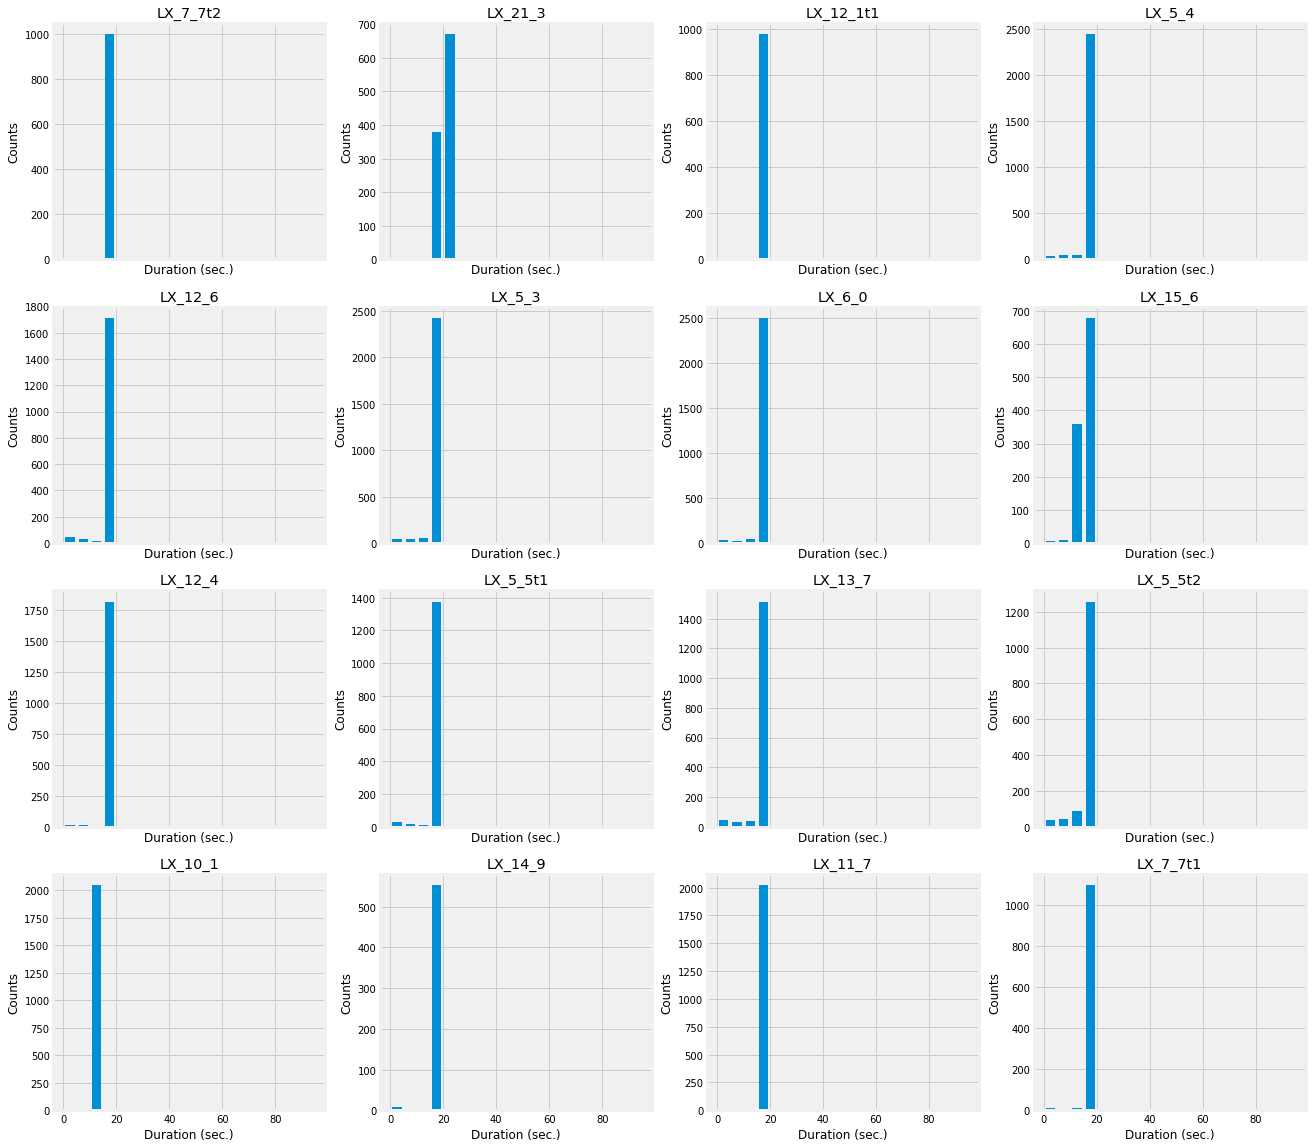

In [26]:
lx_set = set(lx_act_time.lx)
bins = list(range(0,100,5))
num_columns = 4
num_rows = int(np.ceil(len(lx_set)/num_columns))

pl4, our_axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20, 20), 
                             sharex=True, sharey=False)

lx_axes = [ax for ax_row in our_axes for ax in ax_row]

for i, lx in enumerate(lx_set):
    current_ax = lx_axes[i]
    current_lx_data = lx_act_time[lx_act_time.lx==lx].lx_act_time
    current_ax.hist(current_lx_data, rwidth=0.7, bins=bins, density=False)
    current_ax.set_title(lx)
    current_ax.set_ylabel('Counts')
    current_ax.set_xlabel('Duration (sec.)')
  

In [27]:
lx_act_time.groupby(['lx','date']).lx_act_time.describe()

count       mean       std   min    25%   50%    75%  \
lx       date                                                               
LX_10_1  2019-09-01  133.0  13.315789  0.466587  13.0  13.00  13.0  14.00   
         2019-09-02    6.0  13.333333  0.516398  13.0  13.00  13.0  13.75   
         2019-09-07   69.0  13.260870  2.012112   2.0  13.00  14.0  14.00   
         2019-09-08  104.0  13.259615  1.619032   1.0  13.00  13.5  14.00   
         2019-09-09  137.0  13.386861  1.023605   3.0  13.00  13.0  14.00   
         2019-09-10  144.0  13.451389  0.577308  10.0  13.00  13.0  14.00   
         2019-09-11  139.0  13.647482  1.027614   3.0  13.00  14.0  14.00   
         2019-09-12  140.0  13.192857  1.448872   1.0  13.00  13.0  14.00   
         2019-09-13  129.0  13.310078  0.496841  12.0  13.00  13.0  14.00   
         2019-09-14  128.0  13.382812  0.503861  12.0  13.00  13.0  14.00   
         2019-09-15  143.0  13.321678  0.483552  12.0  13.00  13.0  14.00   
         2019-09-16  138.0  13.449275  1.523885   0.0  13.00  14.0  14.00   
         2019-09-17  133.0  13.473684  1.011891   4.0  13.00  14.0  14.00   
         2019-09-18  126.0  13.444444  1.450824   1.0  13.00  14.0  14.00   
         2019-09-21  135.0  13.325926  0.689253   8.0  13.00  13.0  14.00   
         2019-09-22  105.0  13.333333  0.512660  12.0  13.00  13.0  14.00   
         2019-09-23   37.0  13.459459  0.767195  10.0  13.00  14.0  14.00   
         2019-09-24   26.0  13.500000  0.509902  13.0  13.00  13.5  14.00   
         2019-09-25    8.0  13.875000  0.353553  13.0  14.00  14.0  14.00   
         2019-09-26    6.0  13.666667  0.516398  13.0  13.25  14.0  14.00   
         2019-09-28   90.0  13.333333  1.994374   2.0  13.00  14.0  14.00   
LX_11_7  2019-09-01  137.0  16.291971  0.502356  15.0  16.00  16.0  17.00   
         2019-09-02    7.0  16.571429  0.534522  16.0  16.00  17.0  17.00   
         2019-09-07   68.0  15.544118  3.465970   1.0  16.00  17.0  17.00   
         2019-09-08  106.0  15.773585  2.601403   1.0  16.00  16.0  17.00   
         2019-09-09  139.0  16.237410  0.596885  14.0  16.00  16.0  17.00   
         2019-09-10  145.0  16.234483  0.601085  15.0  16.00  16.0  17.00   
         2019-09-11  140.0  16.057143  1.798366   3.0  16.00  16.0  17.00   
         2019-09-12  140.0  15.728571  1.838215   2.0  16.00  16.0  16.00   
         2019-09-13  131.0  15.908397  0.471501  15.0  16.00  16.0  16.00   
...                    ...        ...       ...   ...    ...   ...    ...   
LX_7_7t1 2019-09-17   70.0  15.971429  2.377256   2.0  16.00  16.0  17.00   
         2019-09-18   70.0  15.985714  1.715174   6.0  16.00  16.0  17.00   
         2019-09-21   70.0  15.671429  2.535095   3.0  16.00  16.0  17.00   
         2019-09-22   55.0  15.945455  0.524164  15.0  16.00  16.0  16.00   
         2019-09-23   24.0  16.291667  0.690253  14.0  16.00  16.0  17.00   
         2019-09-24   14.0  16.357143  1.336306  12.0  16.00  17.0  17.00   
         2019-09-25    4.0  16.750000  0.500000  16.0  16.75  17.0  17.00   
         2019-09-26    3.0  16.000000  0.000000  16.0  16.00  16.0  16.00   
         2019-09-28   46.0  16.565217  0.501206  16.0  16.00  17.0  17.00   
LX_7_7t2 2019-09-01   38.0  16.342105  0.480783  16.0  16.00  16.0  17.00   
         2019-09-02    1.0  16.000000       NaN  16.0  16.00  16.0  16.00   
         2019-09-07   34.0  16.676471  0.474858  16.0  16.00  17.0  17.00   
         2019-09-08   53.0  16.396226  0.566352  15.0  16.00  16.0  17.00   
         2019-09-09   68.0  16.352941  0.481438  16.0  16.00  16.0  17.00   
         2019-09-10   72.0  16.250000  0.467236  15.0  16.00  16.0  17.00   
         2019-09-11   69.0  16.652174  0.479770  16.0  16.00  17.0  17.00   
         2019-09-12   68.0  16.147059  0.396428  15.0  16.00  16.0  16.00   
         2019-09-13   64.0  16.078125  0.513460  15.0  16.00  16.0  16.00   
         2019-09-14   64.0  16.156250  0.647798  15.0  16.00  16.0  17.00   
         2019-09-

In [28]:
lx_act_time.groupby(['lx','date']).lx_act_time.value_counts()

lx        date        lx_act_time
LX_10_1   2019-09-01  13.0           91
                      14.0           42
          2019-09-02  13.0            4
                      14.0            2
          2019-09-07  14.0           48
                      13.0           16
                      6.0             2
                      2.0             1
                      10.0            1
                      11.0            1
          2019-09-08  14.0           51
                      13.0           48
                      1.0             1
                      6.0             1
                      8.0             1
                      11.0            1
                      15.0            1
          2019-09-09  13.0           73
                      14.0           63
                      3.0             1
          2019-09-10  13.0           75
                      14.0           68
                      10.0            1
          2019-09-11  14.0           96
      

In [29]:
safe_as_png = True

if safe_as_png:
    pl1.savefig("plot1.png", bbox_inches='tight')
    pl2.savefig("plot2.png", bbox_inches='tight')
    pl3.savefig("plot3.png", bbox_inches='tight')
    pl4.savefig("plot4.png", bbox_inches='tight')

In [30]:
lx_xcpr_time[lx_xcpr_time.lx_closed_time.isna()]

,datetime,lx,lx_closed_time,lx_note,date
1588,2019-09-01 10:54:34,LX_13_7,NaN,XCPR off and no XR on before,2019-09-01
6425,2019-09-02 13:37:27,LX_13_7,NaN,XCPR off and no XR on before,2019-09-02
6438,2019-09-02 13:43:46,LX_13_7,NaN,XCPR off and no XR on before,2019-09-02
6450,2019-09-02 13:55:03,LX_13_7,NaN,XCPR off and no XR on before,2019-09-02
18357,2019-09-08 17:41:19,LX_13_7,NaN,,2019-09-08
56476,2019-09-12 08:15:28,LX_10_1,NaN,,2019-09-12
72505,2019-09-13 13:17:47,LX_15_6,NaN,,2019-09-13
79292,2019-09-13 22:11:58,LX_13_7,NaN,,2019-09-13
95216,2019-09-15 11:36:51,LX_5_4,NaN,,2019-09-15
